In [2]:
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
from heapq import nsmallest
from skimage.feature import hog
from skimage import data, exposure, io
from skimage import color

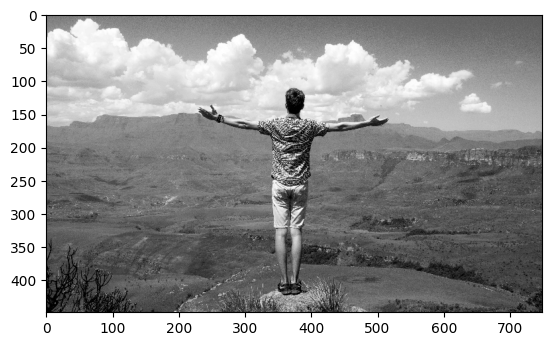

(449, 749)


In [70]:
#image = cv.imread("mask.png")
image = cv.imread("pexels-jjagtenberg-103123.jpg")
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)/255
image = cv.resize(image, (image.shape[1]//8, image.shape[0]//8))
plt.imshow(image, cmap='gray')
plt.show()
print(image.shape)

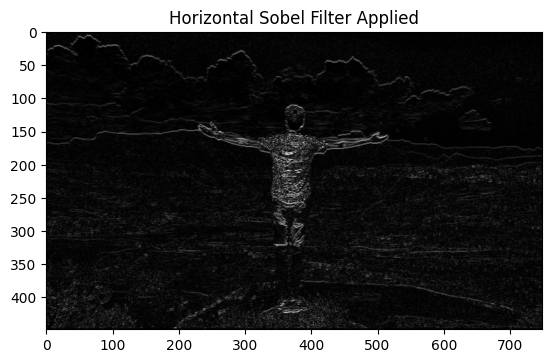

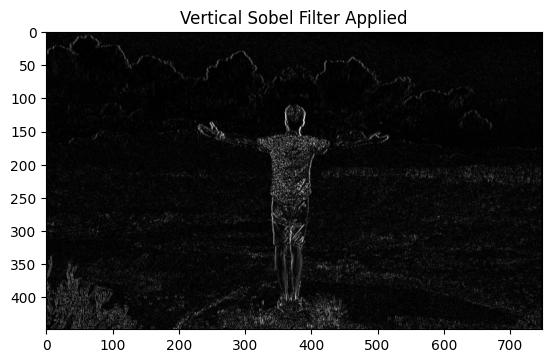

(57, 94, 8)


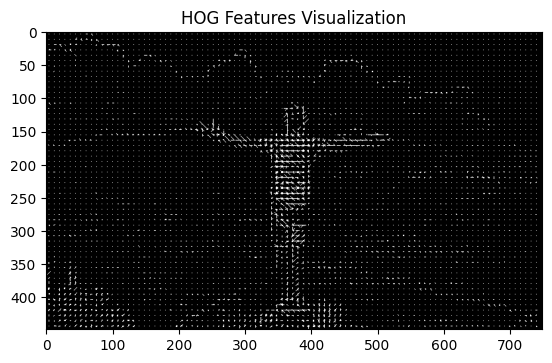

In [74]:
#Task 1
Horz_Sobel = np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
Vert_Sobel = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])

Horz = cv.filter2D(image,-1, Horz_Sobel)
Vert = cv.filter2D(image,-1, Vert_Sobel)

plt.imshow(abs(Horz), cmap='gray')
plt.title("Horizontal Sobel Filter Applied")
plt.show()
plt.imshow(abs(Vert), cmap='gray')
plt.title("Vertical Sobel Filter Applied")
plt.show()

Mag = np.sqrt(np.square(Horz) + np.square(Vert))
Mag = (Mag/np.max(Mag))

Phase = np.int16(np.round(np.arctan2(Vert,Horz)*180/3.1412))
#print(np.unique(Phase))
for row in range(len(Phase)):
    for column in range(len(Phase[row])):
        if (Phase[row,column] < 0):
            Phase[row,column] = 360 + Phase[row,column]
#print(np.unique(Phase))

s = np.array([0,45,90,135,180,225,270,315])
HOGEntire = []
for row in range(0,Phase.shape[0],8):
    HOGRow = []
    for column in range(0,Phase.shape[1],8):

        HOG = {0:0,45:0,90:0,135:0,180:0,225:0,270:0,315:0}
        Patch = Phase[row:row+8,column:column+8]
        PatchMag = Mag[row:row+8,column:column+8]

        for i in range(len(Patch)):
            for j in range(len(Patch[i])):
                if (Patch[i,j] >= 337.5):
                    closest = [315,0]
                    sub1 = 1 - abs(Patch[i,j] - (closest[0] + 22.5))/45
                    sub2 = 1 - sub1
                    #sub2 = 1 - abs(360 - Patch[i,j] - (closest[1] + 22.5))/45

                elif (Patch[i,j] <= 22.5):
                    closest = [315,0]
                    sub1 = 1 - abs(360 + Patch[i,j] - (closest[0] + 22.5))/45
                    sub2 = 1 - sub1
                    #sub2 = 1 - abs(Patch[i,j] - (closest[1] + 22.5))/45
                    
                else:
                    closest = nsmallest(2, s, key=lambda x: abs(x + 22.5 - Patch[i,j]))
                    sub1 = 1 - abs(Patch[i,j] - (closest[0] + 22.5))/45
                    sub2 = 1 - sub1
                    #sub2 = 1 - abs(Patch[i,j] - (closest[1] + 22.5))/45

                #print(sub1,sub2)
                #print(closest,Patch[i,j])

                HOG[closest[0]] = sub1*PatchMag[i,j] + HOG[closest[0]]
                HOG[closest[1]] = sub2*PatchMag[i,j] + HOG[closest[1]]

        HOGRow.append(list(HOG.values()))
    HOGEntire.append(HOGRow)


#print(HOGEntire)
HOGEntire = np.array(HOGEntire, dtype = np.float64)
#print(HOGEntire.shape)
#HOGEntire = np.ndarray.flatten(HOGEntire)
print(HOGEntire.shape)


#Normalizing the Histograms. Not doing this because it ruins the contrast of the image and other objects within it
#for row in range(0,HOGEntire.shape[0],2):
#    for column in range(0,HOGEntire.shape[1],2):
#        sum = np.sqrt(np.sum(np.square(HOGEntire[row: row + 2, column: column + 2, :])))
#        #print(HOGEntire[row: row + 2, column: column + 2, :].shape)
#        if (sum != 0):
#            HOGEntire[row: row + 2, column: column + 2, :] = HOGEntire[row: row + 2, column: column + 2, :]/sum

winSize = (64,64)  # Sliding window size
blockSize = (16,16)  # Block size
blockStride = (16,16)  # Block stride
cellSize = (8,8)  # Cell size
nbins = 8  # Number of orientation bins

# HOG feature size: [num_cells_y, num_cells_x, num_bins]
# Calculate the number of cells per image dimension based on input image size and parameters
image_height, image_width = image.shape
cell_height = image_height // cellSize[1]
cell_width = image_width // cellSize[0]

# Create an empty image to draw HOG features
hog_image = np.zeros((image_height, image_width), dtype=np.uint8)

# Loop through the cells and draw the HOG features
for i in range(cell_height):
    for j in range(cell_width):
        # For each cell, we can visualize the gradient orientations as arrows
        for bin_idx in range(nbins):
            magnitude = HOGEntire[i, j, bin_idx]
            angle = 360 - (bin_idx * (360 / nbins))  # Angle corresponding to the bin. Can add 22.5 to change orientation
            # You can adjust the length of the arrows or vectors here based on magnitude
            if magnitude > 0:
                x_center = (j * cellSize[0]) + (cellSize[0] // 2)
                y_center = (i * cellSize[1]) + (cellSize[1] // 2)
                length = magnitude  # Length proportional to the magnitude
                dx = int(length * np.cos(np.deg2rad(angle)))
                dy = int(length * np.sin(np.deg2rad(angle)))
                cv.line(hog_image, (x_center, y_center), (x_center + dx, y_center + dy), 255, 1)

# Display the image with HOG features
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Features Visualization')
#plt.axis('off')
plt.show()


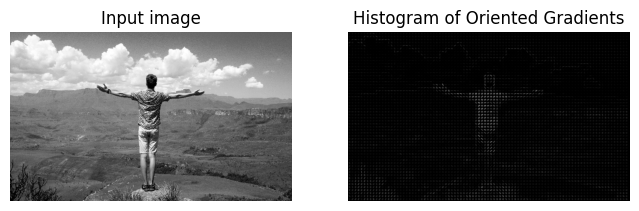

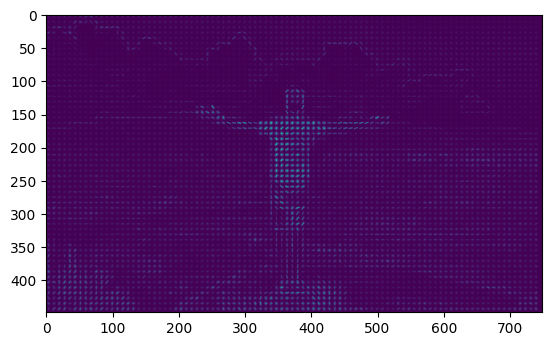

In [39]:
#image_gray = color.rgb2gray(image)
fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

plt.imshow(hog_image, cmap=plt.cm.gray)
plt.show()

In [53]:
print(hog_image.shape)
print(fd.shape)

(449, 749)
(182160,)
